In [5]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(  # Zalando의 기사 이미지 데이터셋으로 60,000개의 학습 예제와 10,000개의 테스트 예제로 이루어져 있습니다.
    root="data",            # root : 학습/테스트 데이터가 저장되는 경로
    train=True,             # train : 학습용 또는 테스트용 데이터셋 여부를 지정
    download=True,          # download=True : root 에 데이터가 없는 경우 인터넷에서 다운로드
    transform=ToTensor()    # transform : 특징(feature)과 정답(label) 변형(transform)을 지정
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

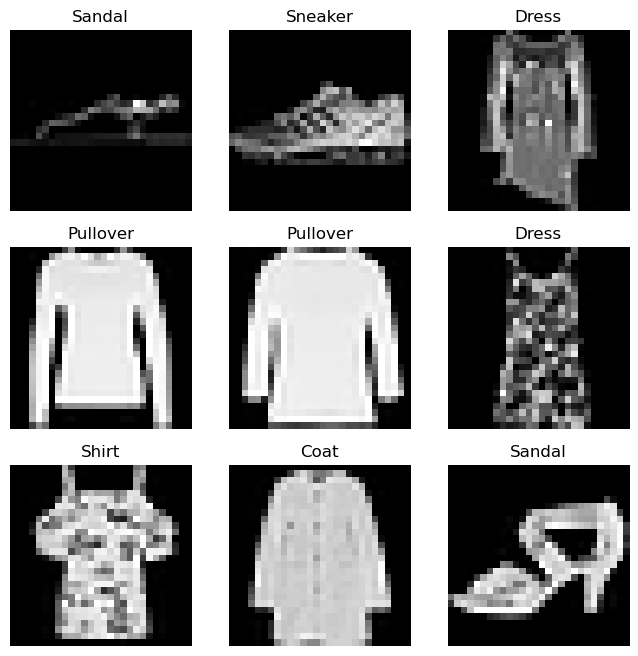

In [6]:
## 데이터셋을 순회하고 시각화하기

# Dataset 에 리스트(list)처럼 직접 접근(index) 가능
# training_data[index], matplotlib 을 사용하여 학습 데이터의 일부를 시각화해보기

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
## 파일에서 사용자 정의 데이터셋 만들기

# 사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 합니다: __init__, __len__, and __getitem__.
# FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, 정답은 annotations_file csv 파일에 별도로 저장

import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):   # 생성자. 클래스가 생성할 때 딱 한번 호출
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):      # 데이터셋의 샘플 개수 반환
        return len(self.img_labels)

    def __getitem__(self, idx):     # 주어진 인덱스(idx)에 해당하는 샘플을 데이터셋에서 불러오고 반환
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])     # 인덱스 기반 이미지 위치 식별
        image = read_image(img_path)                                            # 이미지를 tensor로 변환
        label = self.img_labels.iloc[idx, 1]                                    # csv 데이터로부터 정답(label) 가져오기
        if self.transform:                                                      # 변형(transform) 함수 호출
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label                                                     # tensor 이미지와 label을 반환

In [8]:
## DataLoader로 학습용 데이터 준비하기
# 1. Dataset 은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 합니다.
# 2. 모델을 학습할 때, 일반적으로 샘플들을 《미니배치(minibatch)》로 전달하고, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고,
#   Python의 multiprocessing 을 사용하여 데이터 검색 속도를 높이려고 합니다.
# 3. DataLoader 는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)입니다.

from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
## DataLoader를 통해 순회하기(iterate)
# 1. DataLoader 에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있습니다.
# 2. 각 순회(iteration)는 (각각 batch_size=64 의 특징(feature)과 정답(label)을 포함하는) train_features 와 train_labels 의 묶음(batch)을 반환합니다.
# 3. shuffle=True 로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞입니다.

# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")